In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
daily_sales = pd.read_excel('.\data\Exercise - Daily Sales - FOR CANDIDATE-SENT - SHORT.xlsx', sheet_name = 1, 
                   parse_dates=['Posting Date'])

Necesita generar una primera previsión para las ventas de todo el mes de noviembre de 2017 el 15 de noviembre (el 15 de noviembre es un día laborable). Para esta previsión a partir del 15 de noviembre, no puede utilizar el valor de las ventas diarias del 16 de noviembre o posteriores, ya que obviamente no habrían estado disponibles a partir del 15 de noviembre (

In [3]:
daily_sales.tail()

,Country,Posting Date,Brand,Daily Sales
629,Country 1,2018-02-14,Brand A,11305.37152
630,Country 1,2018-02-19,Brand A,25179.30168
631,Country 1,2018-02-20,Brand A,13206.75222
632,Country 1,2018-02-21,Brand A,10384.84878
633,Country 1,2018-02-23,Brand A,20.41332


In [4]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Country       634 non-null    object        
 1   Posting Date  634 non-null    datetime64[ns]
 2   Brand         634 non-null    object        
 3   Daily Sales   634 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 19.9+ KB


In [5]:
daily_sales.Country.value_counts()

Country 1    634
Name: Country, dtype: int64

In [6]:
cols=['Country', 'Brand']
daily_sales = daily_sales.drop(cols, axis = 1)
daily_sales = daily_sales.set_index('Posting Date')

In [7]:
daily_sales.head()

,Daily Sales
Posting Date,
2015-02-01,30785.21560
2015-05-01,18256.02366
2015-06-01,24168.04468
2015-07-01,3858.64932
2015-12-01,1229.33310


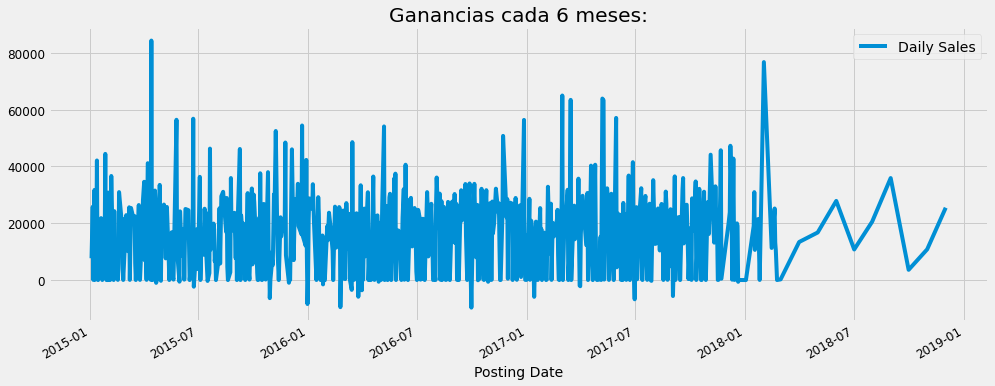

In [8]:
gan = daily_sales.plot(figsize=(15, 6), title='Ganancias cada 6 meses:')

In [9]:
daily_sales_perD = daily_sales.resample("D").sum()
#daily_sales_days.fillna(daily_sales_days["Daily Sales"].min(),inplace=True)
daily_sales_perD.head()

,Daily Sales
Posting Date,
2015-01-04,7676.84934
2015-01-05,0.00000
2015-01-06,25785.81652
2015-01-07,67.01334
2015-01-08,0.00000


In [10]:
#Make the first dataframe of November from 01 to 15:
daily_sales_nov=daily_sales_perD.loc['2017-11-01':'2017-11-15']
daily_sales_nov

,Daily Sales
Posting Date,
2017-11-01,16209.75284
2017-11-02,0.00000
2017-11-03,0.00000
2017-11-04,44108.84254
2017-11-05,0.00000
2017-11-06,0.00000
2017-11-07,0.00000
2017-11-08,0.00000
2017-11-09,16929.62534


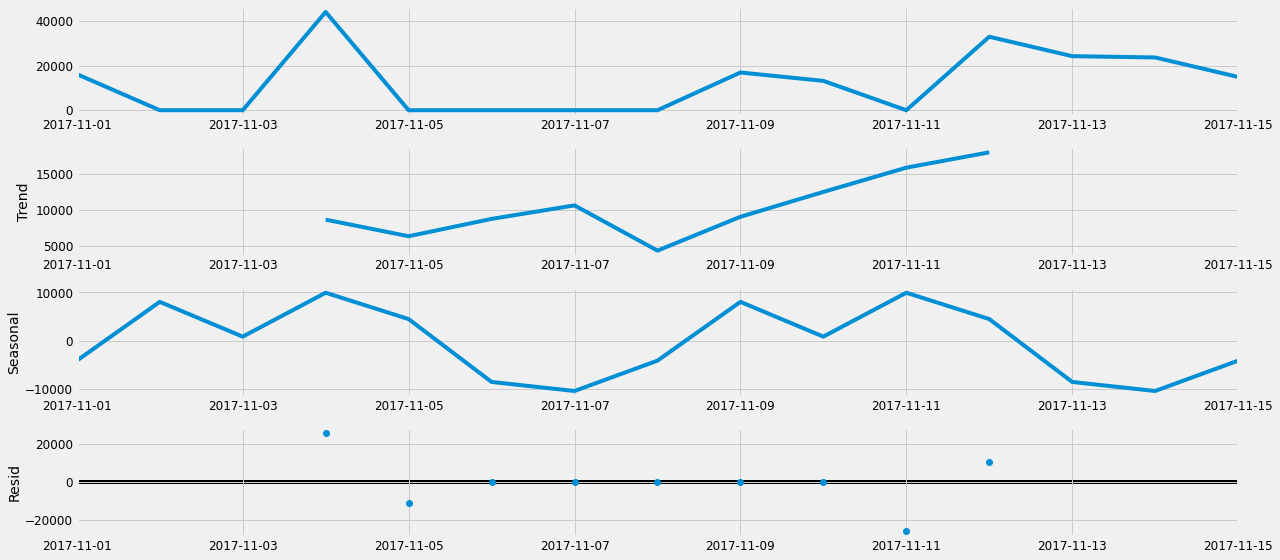

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(daily_sales_nov, model='additive')
fig = decomposition.plot()

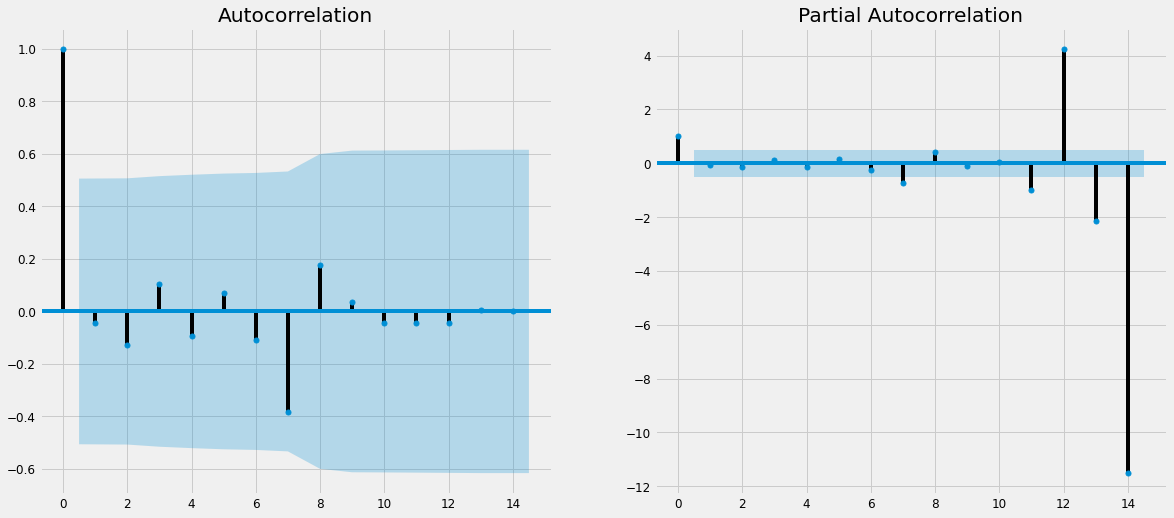

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure()
ax1 = fig.add_subplot(121)
plot_acf(daily_sales_nov, lags=14, ax=ax1)
ax2 = fig.add_subplot(122)
plot_pacf(daily_sales_nov, lags=14, ax=ax2)
plt.show()

# Transformar los datos para convertir la serie en estacionaria

In [13]:
from numpy import inf

#Lo primero que podemos hacer es aplicarle la transformación más usada (la logarítmica)
logy = np.log(daily_sales_nov)

#Then differencing to remove trends
logy[logy == -inf] = 0

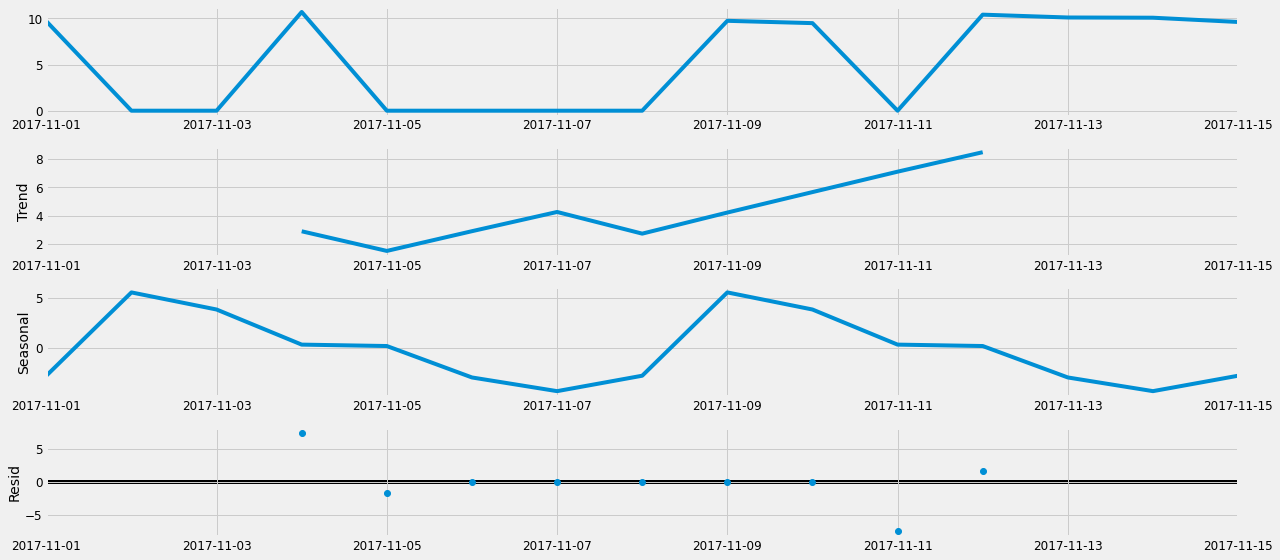

In [15]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(logy, model='additive')
fig = decomposition.plot()

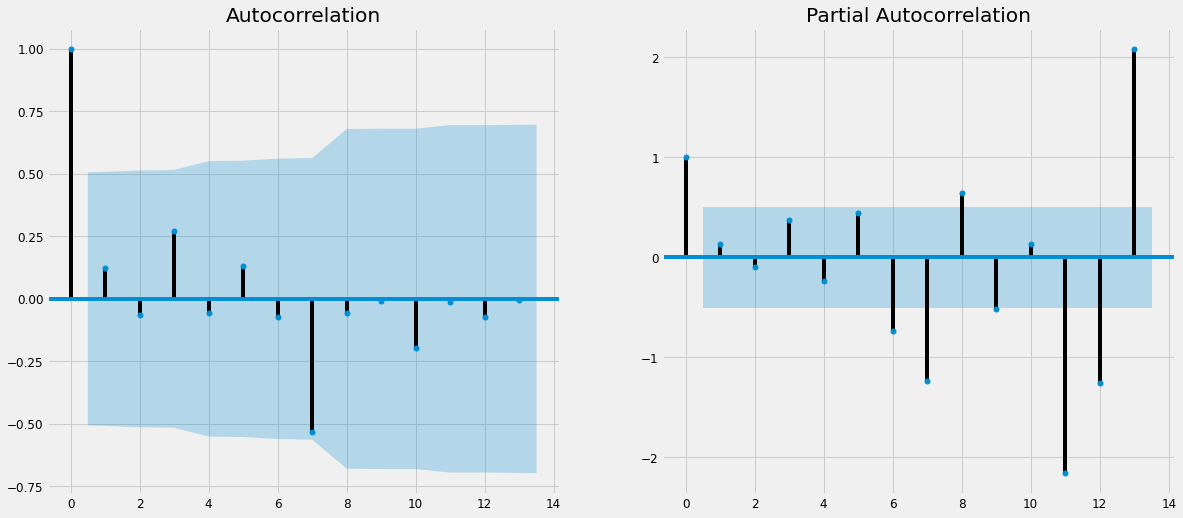

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure()
ax1 = fig.add_subplot(121)
plot_acf(logy, lags=13, ax=ax1)
ax2 = fig.add_subplot(122)
plot_pacf(logy, lags=13, ax=ax2)
plt.show()

In [25]:
import itertools

def grid_search(y, pdq, seasonal_pdq):

    warnings.filterwarnings("ignore")
    aic = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                name = param+param_seasonal
                aic[name] = results.aic
                #print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return aic

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Finding Best Parameter combinations for Seasonal ARIMA...')

aic = grid_search(logy, pdq, seasonal_pdq)
#get the model with minimum aic : min(dict, key=dict.get) will return the key with minimum value in dict
print("Model with Minimum AIC of {} is {}".format(aic[min(aic, key=aic.get)], min(aic, key=aic.get)))

Finding Best Parameter combinations for Seasonal ARIMA...
Model with Minimum AIC of -19.987800771140403 is (0, 0, 1, 1, 1, 0, 7)


In [30]:
mod = sm.tsa.statespace.SARIMAX(logy,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 0, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8599      0.399      2.158      0.031       0.079       1.641
ma.L1        -12.0353     99.473     -0.121      0.904    -206.999     182.928
ar.S.L4       -0.5477      0.272     -2.014      0.044      -1.081      -0.015
sigma2         0.1404      2.266      0.062      0.951      -4.301       4.582


ValueError: operands could not be broadcast together with shapes (9,) (4,) (9,) 

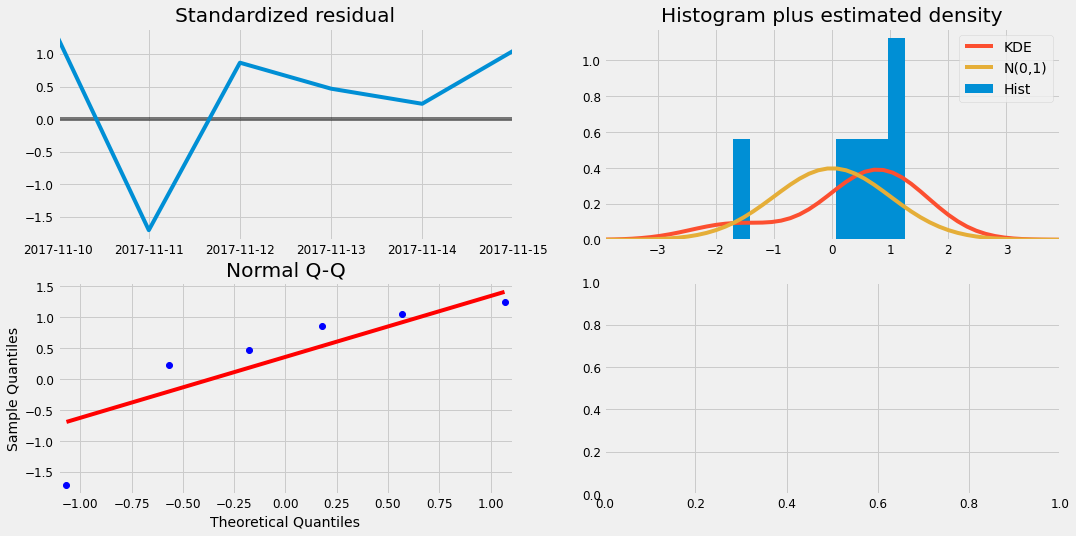

In [31]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()